In [226]:
import pandas as pd

import mix as mix
import db_column_name as db

# offset can be 9, 21. 33, 45, 57, 69
cn = db.ColumnName()

target_minT = pd.read_csv('./data/31286_103.csv')
mix.set_index_date(target_minT, cn.date)
target_minT = target_minT.sort_index()

X = pd.read_csv('./data/character_31286.csv')
mix.set_index_date(X, cn.date)
X = X.sort_index()

X = X.drop([cn.point], axis=1)
X = X[[x for x in X.columns if 'avg' in x or 
       x == cn.offset]]

X = X.groupby([X.index.year, 
           X.index.month, 
           X.index.day]).mean()
a = pd.DataFrame(X.index.tolist(), 
                 columns=['year','month','day'])
X.index = pd.to_datetime(a)
X = X.drop([cn.offset], axis=1)

target_minT.index = target_minT.index.round('D')

X[cn.value] = target_minT
X = mix.clean_dataset(X)

print(X.shape)

(1810, 55)


In [227]:
X['winsorized'] = X[cn.value]
for index, row in X.iterrows(): 
    
    offset_day = pd.to_timedelta(5, unit='day')
    start_date = index - offset_day
    end_date = index + offset_day
    
    s = X.iloc[(X.index >= start_date) & (X.index <= end_date)]
    s = s[[cn.value]]
    
    q = s.quantile([0.1, 0.80])
    
    v = row[cn.value]
    if (v < q.iloc[0, 0]):
        X.loc[index, 'winsorized'] = q.iloc[0, 0]
    elif (v > q.iloc[1, 0]):
        X.loc[index, 'winsorized'] = q.iloc[1, 0]
    
# X[['winsorized', cn.value]].plot(style='.')

In [228]:
X[cn.value] = X['winsorized']
X = X.drop(['winsorized'], axis=1)


In [229]:
import numpy as np
pd.set_option('precision', 10)

import scipy.sparse
import pickle
import xgboost as xgb

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

from pylab import rcParams
rcParams['figure.figsize'] = 20,10

def split_(X, split_year=2016):
    X_train = mix.year_less_eq(X, split_year)
    X_test = mix.year_great(X, split_year)
    return X_train, X_test


X_train, X_test = split_(X)

X_train, target_train = mix.getTarget(X_train)
X_test, target_test = mix.getTarget(X_test)

print("Size train {}".format(X_train.shape))
print("Size train {}".format(X_test.shape))


Size train (1324, 54)
Size train (486, 54)


Mean squared error on train 3.231949110607204 and test 15.987721704936888
Mean absolute error on train 1.3629354205700566 and test 3.1438328755416984
Explained variance score on train 0.9806488379081536 and test 0.9017671080611204
Coefficient of determination on train 0.9806488375083674 and test 0.8983402490302378
Median absolute error on train 1.0876477241516112 and test 2.7029922008514395
Mean absolute percentage error on train 0.33553974889700405 and test 0.9074168437192329


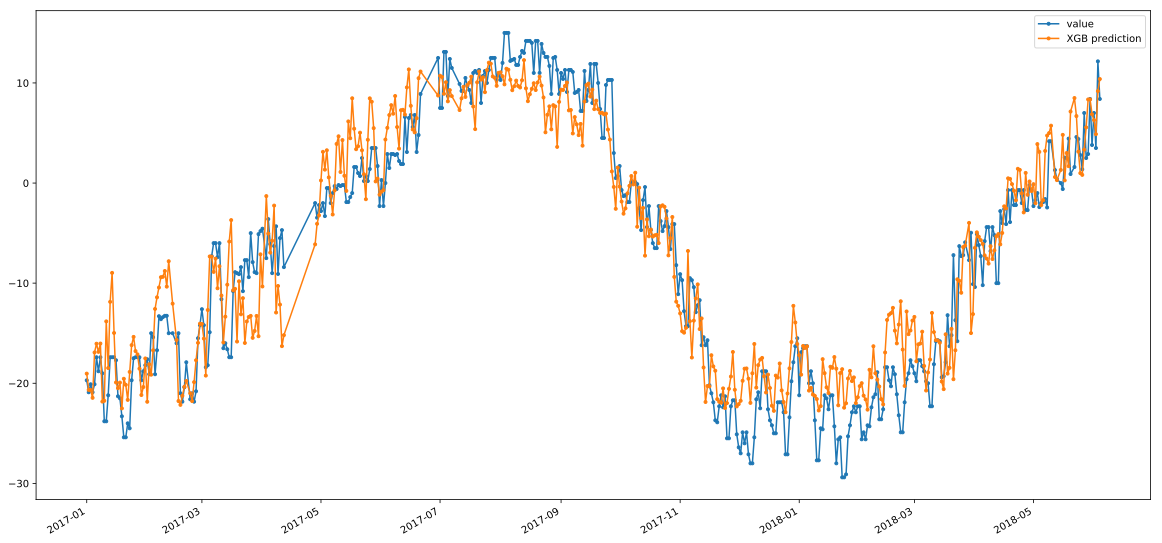

In [231]:
default_params = {
    'verbosity':0,
    'max_depth': 4,
    
    'learning_rate': 0.09,
    'min_child_weight': 6,
#     'subsample':0.8, 
#     'colsample_bytree':0.8,
    'gamma': 16,
}


reg = xgb.XGBRegressor(**default_params)

reg.fit(X_train, target_train[[cn.value]])

target_test.loc[:, 'XGB prediction'] = reg.predict(X_test)
target_train.loc[:, 'XGB prediction'] = reg.predict(X_train)
    
mix.print_mean(target_test, target_train, cn.value, 'XGB prediction') 


target_test.plot(style='.-')

(453, 54)
(167, 54)
Mean squared error on train 1.4569731544290825 and test 14.647422093924465
Mean absolute error on train 0.9380947093019772 and test 3.1764727363567387
Explained variance score on train 0.9911317065338623 and test 0.9083777044621194
Coefficient of determination on train 0.9911317047393191 and test 0.9054745392860946
Median absolute error on train 0.7905491320292155 and test 2.8373745600382487
Mean absolute percentage error on train 0.35858864283888253 and test 1.7194878692425164


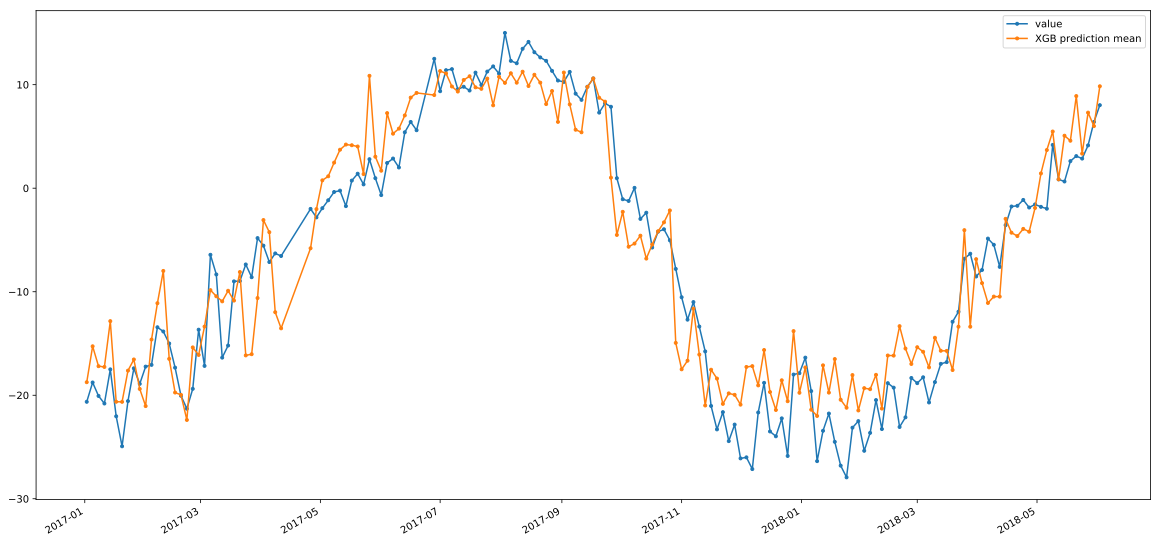

In [232]:

X_ = X.resample('3D').mean()
X_ = mix.clean_dataset(X_)


X_train_mean, X_test_mean = split_(X_)

X_train_mean, target_train_mean = mix.getTarget(X_train_mean)
X_test_mean, target_test_mean = mix.getTarget(X_test_mean)

print(X_train_mean.shape)
print(X_test_mean.shape)

# params = default_param


params_mean = {
    'verbosity':0,
    'max_depth': 4,
    
    'learning_rate': 0.09,
    'min_child_weight': 6,
#     'subsample':0.9, 
#     'colsample_bytree':0.8,
    'gamma': 12,
}

reg = xgb.XGBRegressor(**params_mean)

reg.fit(X_train_mean, target_train_mean[[cn.value]])

target_test_mean.loc[:, 'XGB prediction mean'] = reg.predict(X_test_mean)
target_train_mean.loc[:, 'XGB prediction mean'] = reg.predict(X_train_mean)
    
mix.print_mean(target_test_mean, target_train_mean, cn.value, 'XGB prediction mean') 


target_test_mean.plot(style='.-')